# Import data into python


In [2]:
# Load some libraries 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.decomposition import PCA

sns.set_context("paper", font_scale=2)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [29]:
# Read in metadata file
metadata = pd.read_csv("data_adj/metadata.tsv", sep="\t")

# Read in data
merged_df = pd.read_csv("data_adj/fixed_counts_matrix.tsv", sep="\t", index_col = 0)

In [30]:
merged_df = merged_df.filter(items=['LB_10.5_NA_1', 'LB_10.5_NA_2','LB_11.5_NA_1', 'LB_11.5_NA_2',
                'G_4_F_1', 'G_4_F_2','G_4_M_1', 'G_4_M_2',
                'SM_0_NA_1', 'SM_0_NA_2',
                'MB_3', 'MB_4','MB_5',
                'MT_3', 'MT_4', 'MT_5'])
merged_df.head()

,LB_10.5_NA_1,LB_10.5_NA_2,LB_11.5_NA_1,LB_11.5_NA_2,G_4_F_1,G_4_F_2,G_4_M_1,G_4_M_2,SM_0_NA_1,SM_0_NA_2,MB_3,MB_4,MB_5,MT_3,MT_4,MT_5
gene_id,,,,,,,,,,,,,,,,
ENSMUSG00000099183.1,0,0,0,0,2,4,1,8,1,4,0,0,1,6,2,4
ENSMUSG00000065559.1,96,350,1561,1909,720323,517475,652657,101,298316,447669,27143,24389,27329,1074677,1300194,1256891
ENSMUSG00000065480.1,4,25,92,83,444,373,427,10,2556,4440,334,359,1088,26475,26033,21244
ENSMUSG00000065405.3,18023,20008,13458,15665,26029,16861,16800,17258,17696,20188,125913,135138,120392,27729,28878,25335
ENSMUSG00000065567.1,125,57,111,71,213,240,186,1986,51,87,2074,1710,2018,517,529,416


# PCA (principal component analysis) 
[5-minute explanation of PCA on Youtube](https://www.youtube.com/watch?v=HMOI_lkzW08&t=28s)

In [31]:
input_df = merged_df.transpose() # transpose the matrix
data = input_df.values # just get the numbers
pca = PCA(merged_df.shape[1]) # compute the same # of PCs as samples
pca.fit(data)

PCA(n_components=16)

    prop_variance  pct_variance  PC
0    5.148238e-01  5.148238e+01   1
1    2.693661e-01  2.693661e+01   2
2    1.460582e-01  1.460582e+01   3
3    3.754192e-02  3.754192e+00   4
4    1.637990e-02  1.637990e+00   5
5    7.896447e-03  7.896447e-01   6
6    2.661294e-03  2.661294e-01   7
7    1.825299e-03  1.825299e-01   8
8    1.199558e-03  1.199558e-01   9
9    1.127910e-03  1.127910e-01  10
10   6.375609e-04  6.375609e-02  11
11   2.311052e-04  2.311052e-02  12
12   1.792617e-04  1.792617e-02  13
13   4.969477e-05  4.969477e-03  14
14   2.197735e-05  2.197735e-03  15
15   7.631046e-32  7.631046e-30  16


/opt/apps/python/3.8.0/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


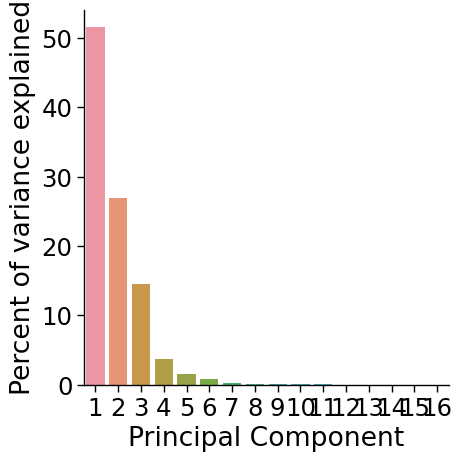

In [32]:
# Make df to plot the percent variance explained
pca_df = pd.DataFrame(data=pca.explained_variance_ratio_,
                      columns=['prop_variance'])

# compute percent variance from proportion variance
pca_df['pct_variance'] = pca_df.prop_variance*100
pca_df['PC'] = list(range(1, merged_df.shape[1]+1))
print(pca_df)

# Use Seaborn library to make categorical bar plot
ax = sns.catplot(data=pca_df, x='PC', y='pct_variance', kind='bar')

# Add nice x and y axis labels
ax.set(ylabel='Percent of variance explained', xlabel='Principal Component')

In [33]:
# first calculate the PCA representation of the data
pca_data = pca.transform(data) 
cols = ['PC{} ({:.1f}%)'.format(pc, var) for pc, var in zip(pca_df.PC, pca_df.pct_variance)]
print(cols)
pca_df = pd.DataFrame(data=pca_data, columns=cols)
pca_df.set_index(input_df.index, inplace=True)


# Perform a merge based on matching indices
pca_df = pca_df.merge(metadata, left_index=True, right_on='Sample')

['PC1 (51.5%)', 'PC2 (26.9%)', 'PC3 (14.6%)', 'PC4 (3.8%)', 'PC5 (1.6%)', 'PC6 (0.8%)', 'PC7 (0.3%)', 'PC8 (0.2%)', 'PC9 (0.1%)', 'PC10 (0.1%)', 'PC11 (0.1%)', 'PC12 (0.0%)', 'PC13 (0.0%)', 'PC14 (0.0%)', 'PC15 (0.0%)', 'PC16 (0.0%)']


## make it pretty!

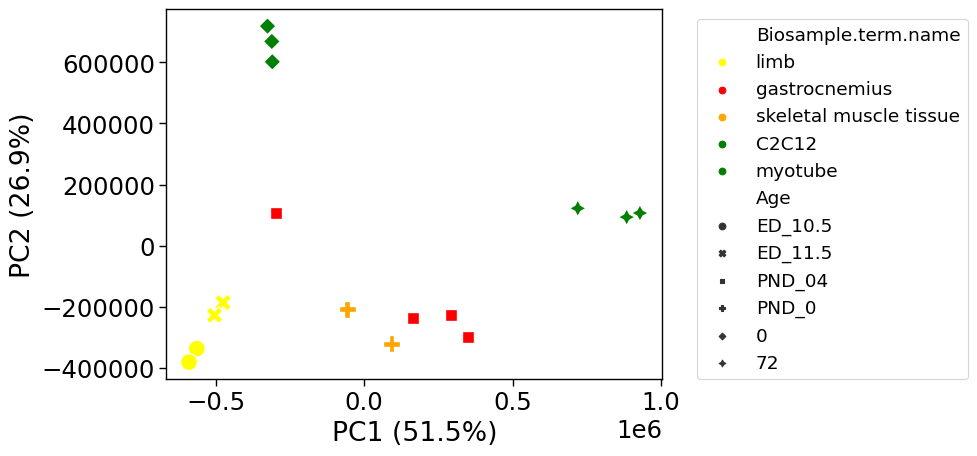

In [34]:
# Make a mini dictionary to assign color to fshd status
c_dict = {'myotube': 'green',
          'C2C12': 'green',
          'skeletal muscle tissue': 'orange',
          'gastrocnemius': 'red',
          'limb': 'yellow'}

ax = sns.scatterplot(data=pca_df, x=cols[0], y=cols[1], 
                     s=150, # size of point
                     hue='Biosample.term.name', palette=c_dict, style='Age')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="x-small")

#export
output_file = "plots/PCA_sm_gastroc.png"
plt.savefig(output_file, dpi=300)

In [86]:
# Get the top weighted genes for PC1 and PC2
top_genes_pc1 = input_df.columns[pca.components_[0].argsort()[::-1]]
top_genes_pc2 = input_df.columns[pca.components_[1].argsort()[::-1]]

# Print the top weighted genes for PC1
print("Top genes for PC1:")
print(top_genes_pc1.to_frame().head(n=15))

# Print the top weighted genes for PC2
print("Top genes for PC2:")
print(top_genes_pc2.to_frame().head(n=15))


Top genes for PC1:
                                   gene_id
gene_id                                   
ENSMUSG00000065559.1  ENSMUSG00000065559.1
ENSMUSG00000065503.1  ENSMUSG00000065503.1
ENSMUSG00000065477.3  ENSMUSG00000065477.3
ENSMUSG00000070139.1  ENSMUSG00000070139.1
ENSMUSG00000070076.2  ENSMUSG00000070076.2
ENSMUSG00000076219.1  ENSMUSG00000076219.1
ENSMUSG00000065437.1  ENSMUSG00000065437.1
ENSMUSG00000076251.1  ENSMUSG00000076251.1
ENSMUSG00000065501.1  ENSMUSG00000065501.1
ENSMUSG00000065410.1  ENSMUSG00000065410.1
ENSMUSG00000070080.1  ENSMUSG00000070080.1
ENSMUSG00000065498.4  ENSMUSG00000065498.4
ENSMUSG00000065480.1  ENSMUSG00000065480.1
ENSMUSG00000065475.2  ENSMUSG00000065475.2
ENSMUSG00000065418.1  ENSMUSG00000065418.1
Top genes for PC2:
                                   gene_id
gene_id                                   
ENSMUSG00000065477.3  ENSMUSG00000065477.3
ENSMUSG00000070076.2  ENSMUSG00000070076.2
ENSMUSG00000076219.1  ENSMUSG00000076219.1
ENSMUSG000000655

In [87]:
merged_df.head()

,G_4_F_1,G_4_F_2,G_4_M_1,G_4_M_2,SM_0_NA_1,SM_0_NA_2,MB_3,MB_4,MB_5,MT_3,MT_4,MT_5
gene_id,,,,,,,,,,,,
ENSMUSG00000099183.1,2,4,1,8,1,4,0,0,1,6,2,4
ENSMUSG00000065559.1,720323,517475,652657,101,298316,447669,27143,24389,27329,1074677,1300194,1256891
ENSMUSG00000065480.1,444,373,427,10,2556,4440,334,359,1088,26475,26033,21244
ENSMUSG00000065405.3,26029,16861,16800,17258,17696,20188,125913,135138,120392,27729,28878,25335
ENSMUSG00000065567.1,213,240,186,1986,51,87,2074,1710,2018,517,529,416


# Heatmap

In [116]:
# order matrix based on expression so we can get some highly-expressed guys
# (but usually for these you'll want to curate the set of genes in a more intelligent way)


merged_df['total'] = merged_df.sum(axis=1)
merged_df.sort_values(by='total', ascending=False, inplace=True)
# merged_df.drop('total', axis=1, inplace=True)

# log2 transform and add pseudocount -- common way to transform RNA-seq data for visualization
merged_df = np.log2(merged_df + 1) 

# show top 15 genes
merged_df_top15 = merged_df[:15] 

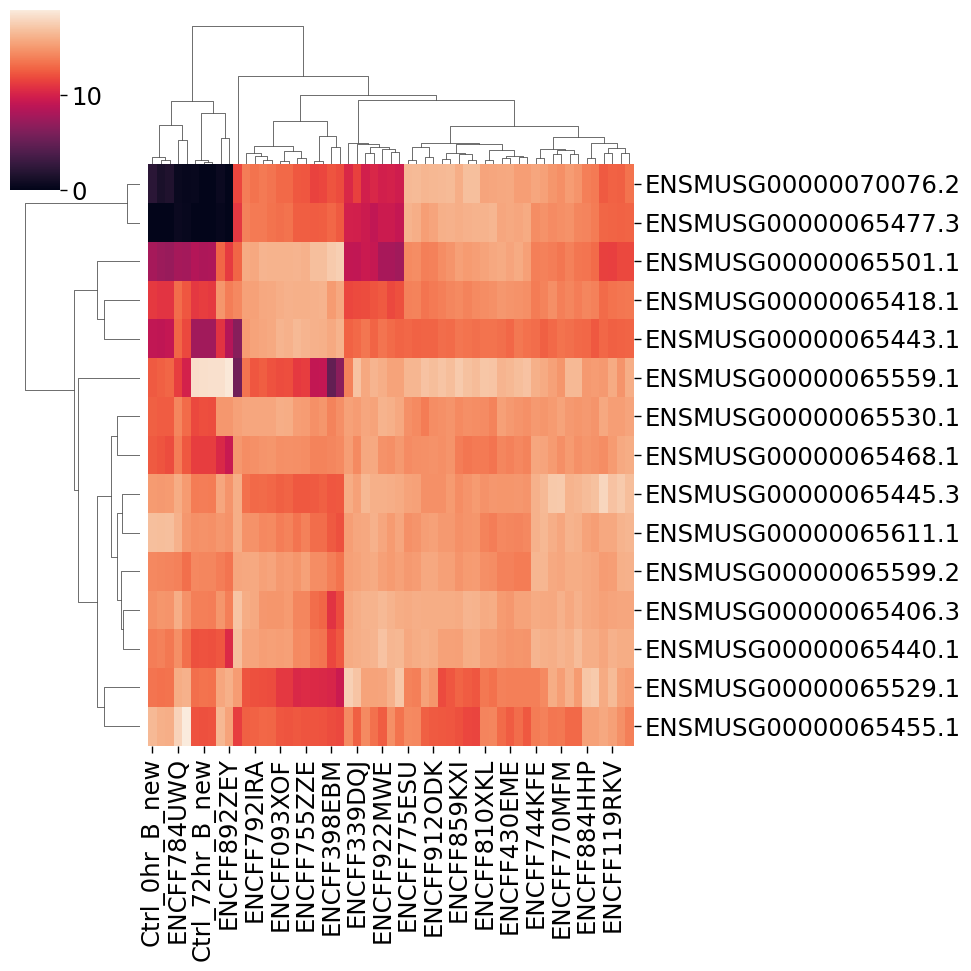

In [113]:
# Use clustermap function in seaborn to make heatmap
ax = sns.clustermap(data=merged_df_top15)

## Check expression of any gene you're interested in 

In [114]:
# subset df for the genes that were in the figure

mygenes = ['PAX7', 'MYOD1', 'MYF5', 'MYOG', 'MYH1', 'MYH2', 'MYH4', 'ATF3']

merged_df_my_genes = merged_df[merged_df.index.isin(mygenes)]

ValueError: The number of observations cannot be determined on an empty distance matrix.

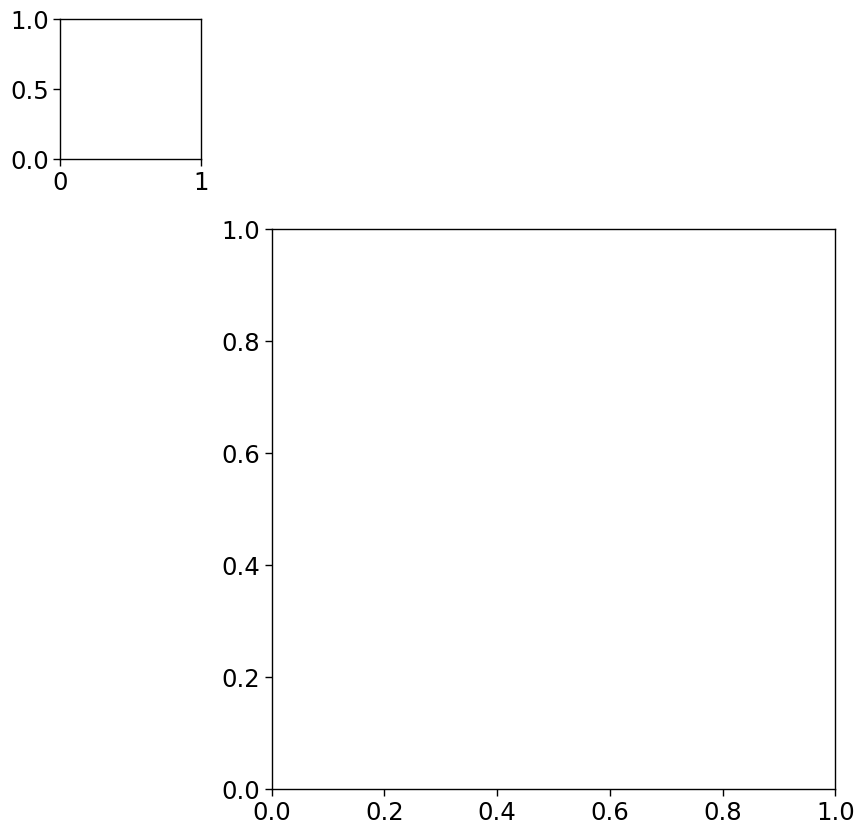

In [115]:
# Turn off column clustering, change color map, and adjust the yticklabels to label every row
ax = sns.clustermap(data=merged_df_my_genes, col_cluster=False, cmap="mako")
plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # y axis labels were getting rotated for some reason
plt.show()
